In [ ]:
import argparse
import json
import os
from os.path import join

import cv2
import torch
import torch.utils.data as data
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
import tensorflow as tf
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
import h5py
from jmetal.algorithm.multiobjective import NSGAII
from jmetal.operator import SBXCrossover, PolynomialMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
import pandas as pd
import pickle as pkl
import sys
import torch.nn.functional as F
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [2]:
# Set the image_size parameter

image_size = 384

In [3]:
# Helper functions (from COUNTGEN repo, adapted by me) 
# Map images from (-1, 1) to (0, 1)

def normalize_0_1(_img, fake = False):
  if fake:
    img = (_img - torch.min(_img))/(torch.max(_img) - torch.min(_img))
  else:
    img = (_img + 1)/(2)
  return img

def denormalize(img):
  return img + 1

In [4]:
# Import Generator and Discriminator (ATTGAN repo). Default values

MAX_DIM = 64 * 16  # 1024

import torch
import torch.nn as nn
from nn import LinearBlock, Conv2dBlock, ConvTranspose2dBlock
from torchsummary import summary

class Generator(nn.Module):
    def __init__(self, enc_dim=64, enc_layers=5, enc_norm_fn='batchnorm', enc_acti_fn='lrelu',
                 dec_dim=64, dec_layers=5, dec_norm_fn='batchnorm', dec_acti_fn='relu',
                 n_attrs=13, shortcut_layers=1, inject_layers=0, img_size=image_size):
        super(Generator, self).__init__()
        self.shortcut_layers = min(shortcut_layers, dec_layers - 1)
        self.inject_layers = min(inject_layers, dec_layers - 1)
        self.f_size = img_size // 2**enc_layers  # f_size = 4 for 128x128
        
        layers = []
        n_in = 3
        for i in range(enc_layers):
            n_out = min(enc_dim * 2**i, MAX_DIM)
            layers += [Conv2dBlock(
                n_in, n_out, (4, 4), stride=2, padding=1, norm_fn=enc_norm_fn, acti_fn=enc_acti_fn
            )]
            n_in = n_out
        self.enc_layers = nn.ModuleList(layers)
        
        layers = []
        n_in = n_in + n_attrs  # 1024 + 13
        for i in range(dec_layers):
            if i < dec_layers - 1:
                n_out = min(dec_dim * 2**(dec_layers-i-1), MAX_DIM)
                layers += [ConvTranspose2dBlock(
                    n_in, n_out, (4, 4), stride=2, padding=1, norm_fn=dec_norm_fn, acti_fn=dec_acti_fn
                )]
                n_in = n_out
                n_in = n_in + n_in//2 if self.shortcut_layers > i else n_in
                n_in = n_in + n_attrs if self.inject_layers > i else n_in
            else:
                layers += [ConvTranspose2dBlock(
                    n_in, 3, (4, 4), stride=2, padding=1, norm_fn='none', acti_fn='tanh'
                )]
        self.dec_layers = nn.ModuleList(layers)
    
    def encode(self, x):
        z = x
        zs = []
        for layer in self.enc_layers:
            z = layer(z)
            zs.append(z)
        return zs
    
    def decode(self, zs, a):
        a_tile = a.view(a.size(0), -1, 1, 1).repeat(1, 1, self.f_size, self.f_size)
        z = torch.cat([zs[-1], a_tile], dim=1)
        for i, layer in enumerate(self.dec_layers):
            z = layer(z)
            if self.shortcut_layers > i:  # Concat 1024 with 512
                z = torch.cat([z, zs[len(self.dec_layers) - 2 - i]], dim=1)
            if self.inject_layers > i:
                a_tile = a.view(a.size(0), -1, 1, 1) \
                          .repeat(1, 1, self.f_size * 2**(i+1), self.f_size * 2**(i+1))
                z = torch.cat([z, a_tile], dim=1)
        return z
    
    def forward(self, x, a=None, mode='enc-dec'):
        if mode == 'enc-dec':
            assert a is not None, 'No given attribute.'
            return self.decode(self.encode(x), a)
        if mode == 'enc':
            return self.encode(x)
        if mode == 'dec':
            assert a is not None, 'No given attribute.'
            return self.decode(x, a)
        raise Exception('Unrecognized mode: ' + mode)
    
class Discriminators(nn.Module):
    # No instancenorm in fcs in source code, which is different from paper.
    def __init__(self, dim=64, norm_fn='instancenorm', acti_fn='lrelu',
                 fc_dim=1024, fc_norm_fn='none', fc_acti_fn='lrelu', n_layers=5, img_size=image_size):
        super(Discriminators, self).__init__()
        self.f_size = img_size // 2**n_layers
        
        layers = []
        n_in = 3
        for i in range(n_layers):
            n_out = min(dim * 2**i, MAX_DIM)
            layers += [Conv2dBlock(
                n_in, n_out, (4, 4), stride=2, padding=1, norm_fn=norm_fn, acti_fn=acti_fn
            )]
            n_in = n_out
        self.conv = nn.Sequential(*layers)
        self.fc_adv = nn.Sequential(
            LinearBlock(1024 * self.f_size * self.f_size, fc_dim, fc_norm_fn, fc_acti_fn),
            LinearBlock(fc_dim, 1, 'none', 'none')
        )
        self.fc_cls = nn.Sequential(
            LinearBlock(1024 * self.f_size * self.f_size, fc_dim, fc_norm_fn, fc_acti_fn),
            LinearBlock(fc_dim, 13, 'none', 'none')
        )
    
    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        return self.fc_adv(h), self.fc_cls(h)

In [5]:
# Instantiate AttGAN class, from ATTGAN repo

class AttGAN():
    def __init__(self, args):
        """Args is a dictionary loaded from the setting.txt file"""
    
        self.enc_dim = args.get('enc_dim')
        self.enc_layers = args.get('enc_layers')
        self.enc_norm = args.get('enc_norm')
        self.enc_acti = args.get('enc_acti')
        self.dec_dim = args.get('dec_dim')
        self.dec_layers = args.get('dec_layers')
        self.dec_norm = args.get('dec_norm')
        self.dect_acti = args.get('dect_acti')
        self.n_attrs = args.get('n_attrs')
        self.shortcut_layers = args.get('shortcut_layers')
        self.inject_layers = args.get('inject_layers')
        self.img_size = args.get('img_size')
        self.dis_dim = args.get('dis_dim')
        self.dis_norm = args.get('dis_norm')
        self.dis_acti = args.get('dis_acti')
        self.dis_fc_dim = args.get('dis_fc_dim')
        self.dis_fc_norm = args.get('dis_fc_norm')
        self.dis_fc_acti = args.get('dis_fc_acti')
        self.dis_layers = args.get('dis_layers')
        
        self.G = Generator(
            self.enc_dim, self.enc_layers, self.enc_norm, self.enc_acti,
            self.dec_dim, self.dec_layers, self.dec_norm, self.dect_acti,
            self.n_attrs, self.shortcut_layers, self.inject_layers, self.img_size
        )
        
        self.D = Discriminators(
            self.dis_dim, self.dis_norm, self.dis_acti,
            self.dis_fc_dim, self.dis_fc_norm, self.dis_fc_acti, self.dis_layers, self.img_size
        )
        
    def eval(self):
        self.G.eval()
        self.D.eval()
        
    def load(self, path):
        states = torch.load(path, map_location=lambda storage, loc: storage)
        if 'G' in states:
            self.G.load_state_dict(states['G'])
        if 'D' in states:
            self.D.load_state_dict(states['D'])
        if 'optim_G' in states:
            self.optim_G.load_state_dict(states['optim_G'])
        if 'optim_D' in states:
            self.optim_D.load_state_dict(states['optim_D'])

In [6]:
# Load settings

with open('./384_shortcut1_inject1_none_hq/setting.txt', 'r') as f:
    gan_args = json.load(f)

In [7]:
# Load dataloader ATTGAN repo

from data import Custom
test_dataset = Custom('./data/custom', './data/list_attr_custom.txt', gan_args.get('img_size'), gan_args.get('attrs'))
test_dataloader = data.DataLoader(
    test_dataset, batch_size=1, num_workers=gan_args.get('num_workers'),
    shuffle=False, drop_last=False
)
# Normalizes data using mean 0.5 and std 0.5 -> range [-1, 1]

# Test Data
imgs = []
atts = []
for idx, (img_a, att_a) in enumerate(test_dataloader):
  imgs.append(img_a), 
  atts.append(att_a)
  
# Receives PIL Image (384, 384, 3) x (0, 255)
# To Tensor scales to (0, 1)
# Normalize scales to (-1, 1) [(0 - 0.5)/0.5, (1 - 0.5)/0.5]
# Outputs tensor (1, 3, 384, 384) x (-1, 1)

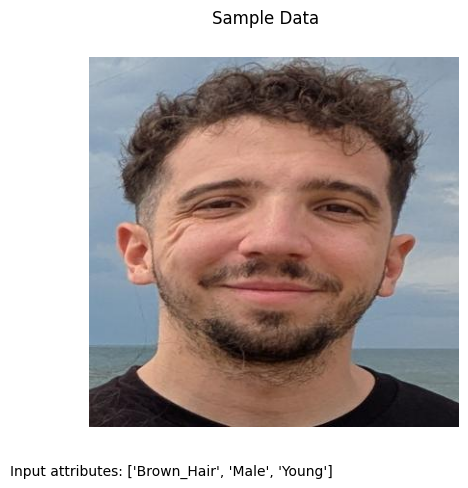

In [8]:
# Print sample data

%matplotlib inline
sample_idx = 2
img = normalize_0_1(imgs[sample_idx]).squeeze(0).permute(1, 2, 0).numpy()
att_list = [att for att, flag in zip(gan_args.get('attrs'), atts[sample_idx].tolist()[0]) if flag == 1]
plt.imshow(img)
plt.axis('off')
plt.suptitle('Sample Data')
plt.figtext(0.10, 0.01, f"""Input attributes: {att_list}""")
plt.show()


In [9]:
# ATTGAN repo

def check_attribute_conflict(att_batch, att_name, att_names):
    def _get(att, att_name):
        if att_name in att_names:
            return att[att_names.index(att_name)]
        return None
    def _set(att, value, att_name):
        if att_name in att_names:
            att[att_names.index(att_name)] = value
    att_id = att_names.index(att_name)
    for att in att_batch:
        if att_name in ['Bald', 'Receding_Hairline'] and att[att_id] != 0:
            if _get(att, 'Bangs') != 0:
                _set(att, 1-att[att_id], 'Bangs')
        elif att_name == 'Bangs' and att[att_id] != 0:
            for n in ['Bald', 'Receding_Hairline']:
                if _get(att, n) != 0:
                    _set(att, 1-att[att_id], n)
                    _set(att, 1-att[att_id], n)
        elif att_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair'] and att[att_id] != 0:
            for n in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
                if n != att_name and _get(att, n) != 0:
                    _set(att, 1-att[att_id], n)
        elif att_name in ['Straight_Hair', 'Wavy_Hair'] and att[att_id] != 0:
            for n in ['Straight_Hair', 'Wavy_Hair']:
                if n != att_name and _get(att, n) != 0:
                    _set(att, 1-att[att_id], n)
        elif att_name in ['Mustache', 'No_Beard'] and att[att_id] != 0:
            for n in ['Mustache', 'No_Beard']:
                if n != att_name and _get(att, n) != 0:
                    _set(att, 1-att[att_id], n)
    return att_batch

In [10]:
# Load AttGAN

attgan = AttGAN(gan_args)
attgan.load('./384_shortcut1_inject1_none_hq/weights.149.pth')
attgan.eval()

In [ ]:
# Legacy code for the Target Classifier model to explain - TF

def Classifier(x, dim=64, n_layers=5, is_training=True):
    bn = partial(batch_norm, is_training=is_training)
    conv_in_lrelu = partial(conv, normalizer_fn=bn, activation_fn=lrelu)

    with tf.variable_scope('Classifier', reuse=tf.AUTO_REUSE):
        for i in range(n_layers):
            d = min(dim * 2**i, MAX_DIM)
            x = conv_in_lrelu(x, d, 4, 2)
            x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
        x = lrelu(fc(x, 1000))
        x = lrelu(fc(x, 2))
        return x

In [15]:
# Load classifier and recreate it in PyTorch

class Classifier(nn.Module):
  def __init__(self, N = 5, dim = 64)  :
      super(Classifier, self).__init__()
            
      self.first_pass = nn.Sequential(
                          nn.Conv2d(in_channels = 3, out_channels = dim, kernel_size = 4, stride = 2, padding = 1),   
                          nn.BatchNorm2d(dim, eps=1e-03, momentum=0.01, affine=False), 
                          nn.LeakyReLU(),
                        )   
      
      self.cnn_module = nn.ModuleList(
                         [nn.Sequential(
                            nn.Conv2d(in_channels = dim * 2 ** i, out_channels = dim * 2 ** (i+1), kernel_size = 4, stride = 2, padding = 1),   
                            nn.BatchNorm2d(dim * 2 ** (i+1), eps=1e-03, momentum=0.01, affine=False), 
                            nn.LeakyReLU(),
                         )
                            for i in range(0, N-1)
                         ] 
                        )
      
      self.flatten = nn.Flatten()
      
      self.fc = nn.Sequential(
                  nn.Linear(dim * 2 ** (N-1) * 4 * 4, 1000),
                  nn.LeakyReLU(),
                  nn.Linear(1000, 2),
                  nn.LeakyReLU()
                )
      
  def forward(self, x):    
    c_1 = self.first_pass(x)
    c = c_1
    for l in self.cnn_module:
     c = l(c)
    flattened_features = self.flatten(c)
    scores = self.fc(flattened_features)
    return scores

In [ ]:
# Import keras classifier from COUNT-GEN repo (DOESNT WORK)
import tensorflow as tf
classifier = tf.keras.models.load_model('./classifier_model.h5')

In [11]:
# Import the h5 file directly

model_path = './classifier_model.h5'

with h5py.File(model_path, 'r') as f:
    if 'model_config' in f.attrs:
        model_config_str = f.attrs['model_config']  # no decode needed
        model_config = json.loads(model_config_str)
        print(json.dumps(model_config, indent=2))  # Pretty print
    else:
        print("No model_config found in HDF5 file.")

{
  "class_name": "Sequential",
  "config": [
    {
      "class_name": "Conv2D",
      "config": {
        "name": "conv2d_1",
        "trainable": true,
        "batch_input_shape": [
          null,
          128,
          128,
          3
        ],
        "dtype": "float32",
        "filters": 16,
        "kernel_size": [
          3,
          3
        ],
        "strides": [
          1,
          1
        ],
        "padding": "valid",
        "data_format": "channels_last",
        "dilation_rate": [
          1,
          1
        ],
        "activation": "relu",
        "use_bias": true,
        "kernel_initializer": {
          "class_name": "VarianceScaling",
          "config": {
            "scale": 1.0,
            "mode": "fan_avg",
            "distribution": "uniform",
            "seed": null
          }
        },
        "bias_initializer": {
          "class_name": "Zeros",
          "config": {}
        },
        "kernel_regularizer": null,
        "bias_r

In [12]:
# Model structure
# Input (N, 128, 128, 3) 
# CONV1 (3, 16, 3, 3). stride = 1, padding = valid, dilation_rate [1, 1] + ReLU. Includes bias. 
# Dropout 0.9
# CONV2 (16, 4, 3, 3), stride = 1, padding = valid, dilation_rate [1, 1] + ReLU
# Flatten - Dense Layer. Sigmoid activation with 1 unit.
#['conv2d_1', 'conv2d_2', 'dense_1', 'dropout_1', 'flatten_1']

with h5py.File('./classifier_model.h5', 'r') as f:
    conv1_w = f['model_weights']['conv2d_1']['conv2d_1']['kernel:0'][()] # 16 filters, 3 kernels, 1 stride, padding valid, dilation rate [1, 1]
    conv1_b = f['model_weights']['conv2d_1']['conv2d_1']['bias:0'][()] #
    conv2_w = f['model_weights']['conv2d_2']['conv2d_2']['kernel:0'][()] #
    conv2_b = f['model_weights']['conv2d_2']['conv2d_2']['bias:0'][()] # 
    dense_1_w = f['model_weights']['dense_1']['dense_1']['kernel:0'][()] #
    dense_1_b = f['model_weights']['dense_1']['dense_1']['bias:0'][()] # 

In [13]:
# Pytorch recreated - classifier

class GenderClassifier(nn.Module):
  def __init__(self)  :
      super(GenderClassifier, self).__init__()
            
      self.cnn_module = nn.Sequential(
                          nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1), 
                          nn.Dropout(0.9),
                          nn.ReLU(),
                          nn.Conv2d(in_channels = 16, out_channels = 4, kernel_size = 3, stride = 1),
                          nn.ReLU()
                        )   
      
      self.flatten = nn.Flatten()
      
      self.fc = nn.Sequential(
                  nn.Linear(61504, 1),
                  nn.Sigmoid()
                )
      
      self.resize = transforms.Resize(128)
      
  def forward(self, x):
    if x.shape[2] or x.shape[3] > 128:
      x = self.resize(x)
    cnn_output = self.cnn_module(x)
    flattened_features = self.flatten(cnn_output)
    scores = self.fc(flattened_features)
    return scores

In [14]:
# Instanciate the classifier and load the weights from COUNT-GEN repo

gender_classifier = GenderClassifier()
with torch.no_grad():
  gender_classifier.cnn_module[0].weight.data = torch.from_numpy(conv1_w).permute(3, 2, 0, 1)
  gender_classifier.cnn_module[0].bias.data = torch.from_numpy(conv1_b)
  gender_classifier.cnn_module[3].weight.data = torch.from_numpy(conv2_w).permute(3, 2, 0, 1)
  gender_classifier.cnn_module[3].bias.data = torch.from_numpy(conv2_b)
  gender_classifier.fc[0].weight.data = torch.from_numpy(dense_1_w).permute(1, 0)
  gender_classifier.fc[0].bias.data = torch.from_numpy(dense_1_b)

In [15]:
# MiVOLO Classifier 

import argparse
import logging
import os
import sys
import ultralytics
import cv2
import torch
import yt_dlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ultralytics.utils.plotting import colors

# Scripts
from mivolo.data.data_reader import InputType, get_all_files, get_input_type
from mivolo.predictor import Predictor
from timm.utils import setup_default_logging

_logger = logging.getLogger("inference")

# Helper function
def get_parser():
    parser = argparse.ArgumentParser(description="PyTorch MiVOLO Inference")
    parser.add_argument("--input", type=str, default=None, required=True, help="image file or folder with images")
    parser.add_argument("--output", type=str, default=None, required=True, help="folder for output results")
    parser.add_argument("--detector-weights", type=str, default=None, required=True, help="Detector weights (YOLOv8).")
    parser.add_argument("--checkpoint", default="", type=str, required=True, help="path to mivolo checkpoint")

    parser.add_argument(
        "--with-persons", action="store_true", default=False, help="If set model will run with persons, if available"
    )
    parser.add_argument(
        "--disable-faces", action="store_true", default=False, help="If set model will use only persons if available"
    )

    parser.add_argument("--draw", action="store_true", default=False, help="If set, resulted images will be drawn")
    parser.add_argument("--device", default="cuda", type=str, help="Device (accelerator) to use.")

    return parser

detector_weights = "./mivolo_models/yolov8x_person_face.pt"
checkpoint =  "./mivolo_models/model_imdb_cross_person_4.22_99.46.pth.tar"
device = "cpu"
input = "/Users/arielmalowany/Desktop/Learning/COUNT-GEN/COUNT-GEN-REPLICABILITY/data/custom" 

parser = get_parser()
args = parser.parse_args(
    [
        "--input",f"""{input}""", 
        "--detector-weights", f"""{detector_weights}""", 
        "--checkpoint", f"""{checkpoint}""", 
        "--device", f"""{device}""",
        "--output", 'output',
        "--with-persons",
        "--draw"
        
    ]
)

predictor = Predictor(args, verbose=True)

/opt/anaconda3/envs/count-gen-demo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


In [16]:
def mivolo_inference(cv2_img, return_age = False):
  detected_objects, out_im = predictor.recognize(cv2_img)
  if detected_objects.n_faces != 0:
    gender_string = detected_objects.genders[0]
    mivolo_gender_score = detected_objects.gender_scores[0]
    age = detected_objects.ages[0]
    if gender_string == "male":
      mivolo_gender_prob = 1 - mivolo_gender_score
    elif gender_string == "female":
      mivolo_gender_prob = mivolo_gender_score
  else:
    mivolo_gender_prob = np.inf
    age = np.inf
  if return_age:
    return mivolo_gender_prob, age
  else:
    return mivolo_gender_prob


0: 640x640 1 person, 1 face, 420.0ms
Speed: 3.0ms preprocess, 420.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 face, 340.5ms
Speed: 1.7ms preprocess, 340.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Text(0.1, 0.01, "Input attributes: ['Brown_Hair', 'Male', 'Young']\nModified attributes: [('Blond_Hair', 1.0), ('Male', -1.0), ('Mouth_Slightly_Open', 1.0), ('No_Beard', 1.0), ('Young', 1.0)]\nReal Disc Score -0.141\nFake Disc Score 0.225\nGender Probability Factual 0.002784\nGender Probability CF 0.99705")

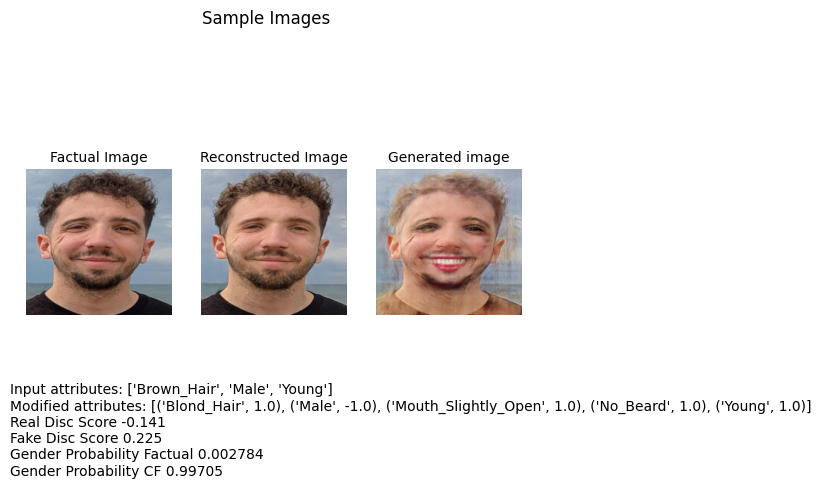

In [17]:
# Generate changes over a image

# arab ariel ['Black_Hair', 'Mustache', 'Bushy_Eyebrows']
# "Bald", "Bangs", "Black_Hair", "Blond_Hair", "Brown_Hair", "Bushy_Eyebrows","Eyeglasses", "Male", "Mouth_Slightly_Open",  "Mustache", "No_Beard", "Pale_Skin", "Young"
# Removed male

test_atts = ['Male', 'No_Beard', 'Mouth_Slightly_Open', 'Young', 'Blond_Hair']
test_ints = [1, 1, 1, -1, 1] # Multiplica!!!. Si el atributo existía queda -1 x test_int, si el atributo no existía queda 1 x test_int
custom_img = True
base_attrs = gan_args.get('attrs')
thres_int = 0.5 # Este valor mide la intensidad del cambio.

sample_idx = 2

img_a = test_dataset[sample_idx][0].unsqueeze(0) # Add batch dimension
att_a = test_dataset[sample_idx][1].unsqueeze(0) # Add batch dimension
    
att_a = att_a.type(torch.float)
att_b = att_a.clone()

for a in test_atts:
  i = base_attrs.index(a)
  att_b[:, i] = 1 - att_b[:, i] # El atributo en el listado de test, lo invierte. Si estaba ahora pasa a ser 0, si no estaba pasa a ser 1.
  att_b = check_attribute_conflict(att_b, base_attrs[i], base_attrs) 

with torch.no_grad():
  att_b_ = (att_b * 2 - 1) * thres_int # Lleva al rango [-1, 1] * test intensity = [-0.5, 0.5]. Si estaba ahora es -1, si no estaba es 1
  att_rec = (att_a * 2 - 1) * thres_int 
  for a, i in zip(test_atts, test_ints):
    att_b_[..., base_attrs.index(a)] = att_b_[..., base_attrs.index(a)] * i / thres_int # Reescala para representar la intensidad del attributo presente
    # Aplica la intensidad multiplicando por el valor seleccionado
  img_fake = attgan.G(img_a, att_b_)
  img_rec = attgan.G(img_a, att_rec)
  d_fake, dc_fake = attgan.D(img_fake)
  d_real, _ = attgan.D(img_a)
  modified_indices = ((att_b_ != -torch.tensor(0.5)) * (att_b_ != -torch.tensor(0))).squeeze(0).nonzero()
  modified_atts = [(base_attrs[i], att_b_[:, i].item()) for i in modified_indices]
  
img_factual = normalize_0_1(img_a).squeeze(0).permute(1, 2, 0).numpy()
img_cfactual = normalize_0_1(img_fake, fake = True).squeeze(0).permute(1, 2, 0).numpy()
img_reconst = normalize_0_1(img_rec, fake = True).squeeze(0).permute(1, 2, 0).numpy()

img_cfactual_for_pred = (img_cfactual * 255).astype(np.uint8)
img_factual_for_pred = (img_factual * 255).astype(np.uint8)
cv2_img_f_sample = cv2.cvtColor(img_factual_for_pred, cv2.COLOR_RGB2BGR)
cv2_img_cf_sample = cv2.cvtColor(img_cfactual_for_pred, cv2.COLOR_RGB2BGR)
new_pred_cf_sample, _ = mivolo_inference(cv2_img_cf_sample, True)
new_pred_f_sample, _ = mivolo_inference(cv2_img_f_sample, True)

%matplotlib inline
att_list = [att for att, flag in zip(base_attrs, atts[sample_idx].tolist()[0]) if flag == 1]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img_factual)
ax2.imshow(img_reconst)
ax3.imshow(img_cfactual)
ax1.title.set_text('Factual Image')
ax1.title.set_fontsize(10)  
ax2.title.set_text('Reconstructed Image')
ax2.title.set_fontsize(10) 
ax3.title.set_text('Generated image')
ax3.title.set_fontsize(10) 
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
fig.suptitle('Sample Images')
plt.figtext(0.10, 0.01, f"""Input attributes: {att_list}\nModified attributes: {modified_atts}\nReal Disc Score {round(d_real.item(), 3)}\nFake Disc Score {round(d_fake.item(), 3)}\nGender Probability Factual {round(new_pred_f_sample, 6)}\nGender Probability CF {round(new_pred_cf_sample, 6)}""")


0: 640x640 1 person, 1 face, 356.0ms
Speed: 2.0ms preprocess, 356.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Text(0.2, -0.05, "Input attributes: ['Brown_Hair', 'Young']\nCOUNT-GEN Gender score: 0.017245056107640266\nMiVolo Gender score: 0.9971235394477844\nMiVolo Age: 32.91")

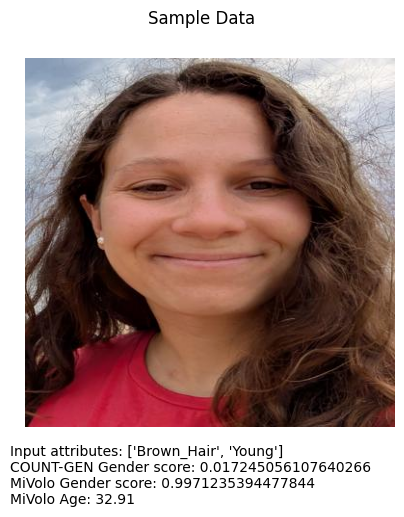

In [18]:
# Test the classifiers

img1_torch = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
gender_classifier.eval()

%matplotlib inline
sample_idx = 3
base_img = normalize_0_1(imgs[sample_idx])
img = base_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
img = (img * 255).astype(np.uint8)
cv2_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
att_list = [att for att, flag in zip(base_attrs, atts[sample_idx].tolist()[0]) if flag == 1]
plt.imshow(img)
plt.suptitle('Sample Data')
plt.axis('off')
gender_score = gender_classifier(base_img).item()
mivolo_gender_prob, age = mivolo_inference(cv2_img, True)
plt.figtext(0.2, -0.05, f"""Input attributes: {att_list}\nCOUNT-GEN Gender score: {gender_score}\nMiVolo Gender score: {mivolo_gender_prob}\nMiVolo Age: {age}""")

In [19]:
class AttGanPlausibleCounterfactualProblem(FloatProblem):
    """
    Problem of finding counterfactuals for the AttGAN model -- Pytorch
    """

    def __init__(self, number_of_variables: int = 13, image=None,
                 code=None,  
                 decoder=None,
                 discriminator=None,
                 classifier=None,
                 original_pred=None,
                 desired_pred = None,
                 use_mivolo = True,
                 threshold_int = 0.5):
        """ :param number_of_variables: number of decision variables of the problem.
        """
        self._number_of_variables = number_of_variables
        self._number_of_objectives = 3
        self._number_of_constraints = 0

        self.obj_directions = [self.MINIMIZE] * self._number_of_objectives
        self.obj_labels = ['$ f_{} $'.format(i) for i in range(self._number_of_objectives)]

        self.lower_bound = number_of_variables * [-1.0]
        self.upper_bound = number_of_variables * [1.0]

        self.image = image.detach()
        self.code = code.detach()
        self.decoder = decoder
        self.original_pred = original_pred
        self.desired_pred = torch.tensor(desired_pred)
        original_pred_decision = 0
        if original_pred >= 0.5:
            original_pred_decision = 1
        self.original_pred_decision = original_pred_decision
        self.discriminator = discriminator
        self.classifier = classifier
        self.counterfactuals = pd.DataFrame(data=[], columns=[
            'CounterfactualImage', 'ClassifierProbability',
            'DiscriminatorDistance', 'OriginalCode', 'CounterfactualCode'])
        self.use_mivolo = use_mivolo
        
    def name(self):
      return "AttGanPlausibleCounterfactualProblem"

    def number_of_objectives(self):
      return self._number_of_objectives
      
    def number_of_constraints(self):
      return self._number_of_constraints
    
    def number_of_variables(self):
      return self._number_of_variables

    def evaluate(self, solution: FloatSolution) -> FloatSolution:
      with torch.no_grad():
        df = self.counterfactuals
        real_image = self.image
        code = self.code
        new_code = torch.tensor(solution.variables).unsqueeze(0)
        
        # Real Image, new code
        new_image = self.decoder(real_image, new_code)
        new_image_n = normalize_0_1(new_image)
        img = new_image_n.squeeze(0).permute(1, 2, 0).cpu().numpy()
        
        if self.use_mivolo:
          img = (img * 255).astype(np.uint8)
          cv2_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
          new_pred, _ = mivolo_inference(cv2_img, True)
          if new_pred is None:
             new_pred = np.inf
        else:
          new_pred = self.classifier(new_image_n).item()
        
        solution.prediction = new_pred
        
        # Pass the real image through the discriminator
        d_real, _ = self.discriminator(real_image)
        d_real = d_real[0].float().item() # Discriminator score
        
        # Pass the fake image through the discriminator
        d_fake, _ = self.discriminator(new_image)
        d_fake = d_fake[0].float().item() # Discriminator score

        pred_decision = 0
        if new_pred >= 0.5:
          pred_decision = 1

        code_difference = torch.sum((new_code - code) ** 2).float().item()
        #pred_difference = (self.original_pred - new_pred).squeeze().float().item() # Maximize
        disc_difference = (d_real - d_fake) # > 0 better

        solution.objectives[0] = code_difference #torch.sum(torch.abs(new_code - code)).float().item()
        solution.objectives[1] = torch.abs(self.desired_pred - new_pred) # minimize the new score for the base class
        solution.objectives[2] = np.abs(disc_difference) # maximize the gan score for the fake image

        solution.counterfactualImage = new_image # Tensor directo del decoder

        #if (pred_decision != self.original_pred_decision) and (disc_difference < 0):
        #    f, ax = plt.subplots(1, 2)
        #    real_image_to_plot = normalize(real_image).squeeze(0).permute(1, 2, 0).numpy()
        #     new_image_to_plot = normalize(new_image).squeeze(0).permute(1, 2, 0).numpy()
        #     ax[0].imshow(real_image_to_plot)
        #     ax[1].imshow(new_image_to_plot)
            #files = os.listdir('./Counterfactuals/images/')
            #plt.savefig('./Counterfactuals/images/Count' + str(len(files)) + '.png')
        #   plt.close(f)
        return solution

In [ ]:
# Generate CFs

max_evals = 1000
sample_idx = 3
desired_pred = 0
pop_size = 100
img_tensor = imgs[sample_idx]
base_img = normalize_0_1(img_tensor)
img = base_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
img = (img * 255).astype(np.uint8)
cv2_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
atts_tensor = atts[sample_idx]
att_list = [att for att, flag in zip(base_attrs, atts[sample_idx].tolist()[0]) if flag == 1]
prediction_orig, _ = mivolo_inference(cv2_img, True)

problem = AttGanPlausibleCounterfactualProblem(
            image = img_tensor, 
            code = atts_tensor, 
            decoder = attgan.G, 
            discriminator = attgan.D, 
            classifier = predictor, 
            original_pred = prediction_orig,
            use_mivolo=True,
            desired_pred = desired_pred
          )

algorithm = NSGAII(
             problem=problem,
             population_size=pop_size,
             offspring_population_size=pop_size,
             mutation=PolynomialMutation(
                 probability=1/problem._number_of_variables,
                 distribution_index=20),
             crossover=SBXCrossover(probability=1.0, distribution_index=20),
             termination_criterion=StoppingByEvaluations(max_evaluations=max_evals)
         )
        
algorithm.run()
pareto_front = algorithm.result()

with open('./Counterfactuals/Front_' + str(sample_idx) + '.pkl', 'wb') as f:
  pkl.dump(pareto_front, f, pkl.HIGHEST_PROTOCOL)

In [61]:
# Valid CFs

with open('./Counterfactuals/Front_2.pkl', 'rb') as f:
    front = pkl.load(f)

raw_x_data = []
raw_y_data = []
new_preds = []
new_attributes = []
raw_z_data = []
image_data = []

for sol in front:
    x = float(sol.objectives[0])
    y = float(sol.objectives[1])
    z = float(sol.objectives[2])
    new_code = torch.tensor(sol.variables)
    new_pred = sol.prediction
    if np.isfinite(x) and np.isfinite(y) and np.isfinite(z):
      raw_x_data.append(x)
      raw_y_data.append(y)
      raw_z_data.append(z)
      new_preds.append(new_pred)
      new_attributes.append(new_code)
      image_data.append(sol.counterfactualImage)

In [ ]:
base_attrs = gan_args.get('attrs')
thres_int = 0.5 # Este valor mide la intensidad del cambio.

img_a = test_dataset[sample_idx][0].unsqueeze(0) # Add batch dimension
att_a = test_dataset[sample_idx][1].unsqueeze(0) # Add batch dimension
    
att_a = att_a.type(torch.float)
att_b = att_a.clone()

for a in test_atts:
  i = base_attrs.index(a)
  att_b[:, i] = 1 - att_b[:, i] # El atributo en el listado de test, lo invierte. Si estaba ahora pasa a ser 0, si no estaba pasa a ser 1.
  att_b = check_attribute_conflict(att_b, base_attrs[i], base_attrs) 

with torch.no_grad():
  att_b_ = (att_b * 2 - 1) * thres_int # Lleva al rango [-1, 1] * test intensity = [-0.5, 0.5]. Si estaba ahora es -1, si no estaba es 1
  att_rec = (att_a * 2 - 1) * thres_int 
  for a, i in zip(test_atts, test_ints):
    att_b_[..., base_attrs.index(a)] = att_b_[..., base_attrs.index(a)] * i / thres_int # Reescala para representar la intensidad del attributo presente
    # Aplica la intensidad multiplicando por el valor seleccionado
  img_fake = attgan.G(img_a, att_b_)
  img_rec = attgan.G(img_a, att_rec)
  d_fake, dc_fake = attgan.D(img_fake)
  d_real, _ = attgan.D(img_a)
  modified_indices = ((att_b_ != -torch.tensor(0.5)) * (att_b_ != -torch.tensor(0))).squeeze(0).nonzero()
  modified_atts = [(base_attrs[i], att_b_[:, i].item()) for i in modified_indices]

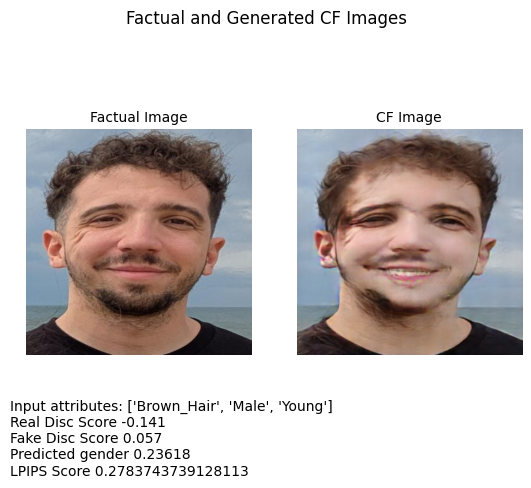

In [ ]:
# Sample CFs

sample_idx = 2
atts_tensor = atts[sample_idx]

with torch.no_grad():
  cf_idx = 15
  att_fake = new_attributes[cf_idx].unsqueeze(0)
  img_fake = attgan.G(imgs[sample_idx], att_fake * 0.5)
  d_fake, dc_fake = attgan.D(img_fake)
  modified_indices = ((att_fake != -torch.tensor(0.5)) * (att_fake != -torch.tensor(0))).squeeze(0).nonzero()
  modified_atts = [(atts_tensor.squeeze(0)[i], att_fake[:, i].item()) for i in modified_indices]

  img_factual = normalize_0_1(imgs[sample_idx]).squeeze(0).permute(1, 2, 0).numpy()
  img_cfactual = normalize_0_1(img_fake, fake = True).squeeze(0).permute(1, 2, 0).numpy()
  lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg', reduction='none')
  lpips_distance = lpips(imgs[sample_idx], img_fake)
  
  %matplotlib inline
  att_list = [att for att, flag in zip(base_attrs, atts[sample_idx].tolist()[0]) if flag == 1]
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(img_factual)
  ax2.imshow(img_cfactual)
  ax1.title.set_text('Factual Image')
  ax1.title.set_fontsize(10)
  ax2.title.set_text('CF Image')
  ax2.title.set_fontsize(10) 
  ax1.axis('off')
  ax2.axis('off')
  fig.suptitle('Factual and Generated CF Images')
  plt.figtext(0.10, 0.01, f"""Input attributes: {att_list}\nReal Disc Score {round(d_real.item(), 3)}\nFake Disc Score {round(d_fake.item(), 3)}\nPredicted gender {round(new_preds[cf_idx], 5)}\nLPIPS Score {lpips_distance}""")

In [63]:
# Helper functions for plotting Pareto front and data

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

valid_cfs = len(image_data)

def min_max(_x, _min=None, _max=None):
    if _min is None and _max is None:
        return (_x - np.min(_x)) / (np.max(_x) - np.min(_x))
    else:
        return (_x - _min) / (_max - _min)

def plot_front(_ax, _c_ax, _x, _y, _z):
    _ax.set_xlabel('Code D')
    _ax.set_ylabel('Adversarial attack')
    _ax.set_zlabel('Plausibility')
    _cs = _ax.scatter3D(_x, _y, _z, c=(_x + _y + _z))
    plt.colorbar(_cs,
                 orientation="horizontal", pad=0.2, ax=_c_ax)
    return _cs.cmap

def plot_data(_ax, _l_ax, _x, _y, _z, _cmap):
    _ax.set_ylim((0, np.max(_x + _y + _x) * 1.1))
    _ax.scatter(range(valid_cfs), _x, s=1, c='red',
                alpha=0.3)
    l1, = _ax.plot(_x, c='red', label='Code D (X)', alpha=0.3)

    _ax.scatter(range(valid_cfs), _y, s=1, c='green',

                alpha=0.3)
    l2, = _ax.plot(_y, c='green', label='Prediction (Y)', alpha=0.3)

    _ax.scatter(range(valid_cfs), _z, s=1, c='blue',

                alpha=0.3)
    l3, = _ax.plot(_z, c='blue', alpha=0.3, label='Plausibility (Z)')

    _ax.scatter(range(valid_cfs), _x + _y + _z,
                s=2,
                marker='x',
                c=(_x + _y + _z),
                cmap=_cmap)
    l4, = _ax.plot(_x + _y + _z,
                   c='black',
                   label='X + Y + Z',
                   alpha=0.3)
    _l_ax.legend(handles=[l1, l2, l3, l4],
                 fontsize='xx-small')

/var/folders/5j/bzx1pm2n5fg14pqsndlhvb700000gn/T/ipykernel_6514/1490929879.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  highlight_cmap = cm.get_cmap('Set3')
/var/folders/5j/bzx1pm2n5fg14pqsndlhvb700000gn/T/ipykernel_6514/1490929879.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  data_ax.scatter(idx, value,
/var/folders/5j/bzx1pm2n5fg14pqsndlhvb700000gn/T/ipykernel_6514/1490929879.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have preced

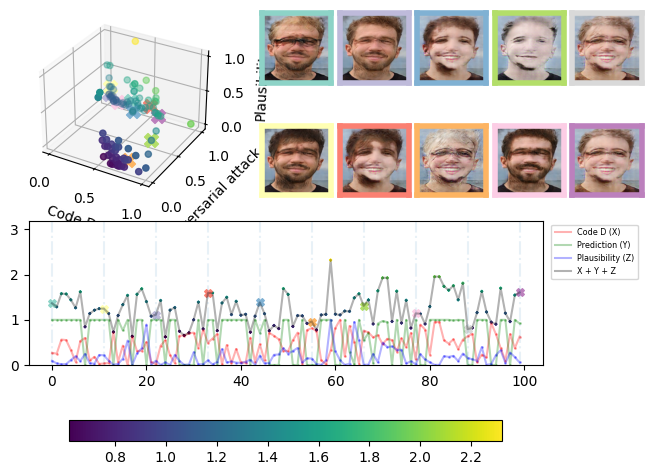

In [64]:
%matplotlib inline

x_data = min_max(raw_x_data).reshape(-1)
y_data = min_max(raw_y_data).reshape(-1)
z_data = min_max(raw_z_data).reshape(-1)

fig = plt.figure(constrained_layout=True)
spec2 = fig.add_gridspec(5, 17)
front_ax = fig.add_subplot(spec2[0:3, 0:6], projection='3d')
data_ax = fig.add_subplot(spec2[3:5, 0:16])
legend_ax = fig.add_subplot(spec2[3:5, 16])
legend_ax.axis('off')
legend_ax.set_xticks([])
legend_ax.set_yticks([])
n_row = 2
n_col = 5
counter_spec = gridspec.GridSpecFromSubplotSpec(n_row, n_col,
                                                subplot_spec=spec2[0:3, 7:17])
counterfactuals_ax = []
for col in range(n_col):
    for row in range(n_row):
        ax = fig.add_subplot(counter_spec[row, col])
        ax.set_xticks([])
        ax.set_yticks([])
        counterfactuals_ax.append(ax)
        
# PLOT front
custom_cmap = plot_front(front_ax, data_ax, x_data, y_data, z_data)

# PLOT data
plot_data(data_ax, legend_ax, x_data, y_data, z_data, custom_cmap)

# PLOT Counterfactuals
count_idx = np.linspace(start=0, stop=len(image_data) - 1, num=10, dtype=int)

highlight_cmap = cm.get_cmap('Set3')
for i, idx in enumerate(count_idx):
    value = x_data[idx] + y_data[idx] + z_data[idx]

    counterfactuals_ax[i].imshow(min_max(image_data[idx].squeeze(0).permute(1, 2, 0).cpu().numpy()))

    plt.setp(counterfactuals_ax[i].spines.values(),
             color=highlight_cmap(i),
             linewidth=4)
    data_ax.axvline(x=idx, linestyle='-.', alpha=0.1)
    data_ax.scatter(idx, value,
                    s=30,
                    marker='X',
                    c=highlight_cmap(i))
    front_ax.scatter3D(x_data[idx], y_data[idx], z_data[idx],
                       c=highlight_cmap(i),
                       s=valid_cfs,
                       marker='X')
plt.show()

In [65]:
# Load sample training data

class CelebA_HQ(data.Dataset):
    def __init__(self, data_path, image_size, mode):
        super(CelebA_HQ, self).__init__()
        self.data_path = data_path
        
        images = ['{:d}.jpg'.format(i) for i in range(30000)]
        
        if mode == 'train':
            self.images = images[:28000]
        if mode == 'valid':
            self.images = images[28000:28500]
        if mode == 'test':
            self.images = images[28500:]
        
        self.tf = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
                                       
        self.length = len(self.images)
    def __getitem__(self, index):
        img = self.tf(Image.open(os.path.join(self.data_path, self.images[index])))
        return img
    def __len__(self):
        return self.length

In [ ]:
# Load N samples

celeba_path = '/Users/arielmalowany/Desktop/Learning/COUNT-GEN/COUNT-GEN-REPLICABILITY/celeba_hq_dataset/CelebA-HQ-img'

sample_celeba_data = CelebA_HQ(
                       data_path = celeba_path,
                       image_size = 128,
                       mode = 'train'
                     )

sample_celeba_dataloader = data.DataLoader(
                             sample_celeba_data, batch_size=100, num_workers=gan_args.get('num_workers'),
                             shuffle=True, drop_last=False
                          )

In [66]:
# Load batch of N random images

data_iterator = iter(sample_celeba_dataloader)
sample_images = next(data_iterator)

In [67]:
# Metrics

# Validity and size

count_valid_cfs = len([y for y in raw_y_data if y < 0.5])
valid_cfs_idx = [i for i, y in enumerate(raw_y_data) if y < 0.5]
valid_cf_images = torch.stack([image_data[i] for i in valid_cfs_idx]).squeeze(1)
valid_cf_atts = torch.stack([new_attributes[i] for i in valid_cfs_idx])
valid_cfs_pct = count_valid_cfs / pop_size
size = len(raw_x_data) / pop_size

# Proximity - features

avg_distance = np.mean(raw_x_data)

# Proximity - images

lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg', reduction='none') # LPIPS needs the images to be in the [-1, 1] range.
lpips_score = 0
for cf in valid_cf_images:
  lpips_score += lpips(imgs[sample_idx], cf.unsqueeze(0))
lpips_score /= count_valid_cfs

# Minimality - average number of features changed

avg_features_changed = torch.sum(torch.abs(valid_cf_atts - atts_tensor) > 0.05)/count_valid_cfs

# Diversity - average distance between attributes

distances = torch.sqrt(((valid_cf_atts - atts_tensor) ** 2).sum(-1))
mean_distance = torch.mean(distances)

# Diversity - standard deviation for each attribute

attribute_deviations = torch.std(valid_cf_atts, dim = 0)
attribute_means = torch.mean(valid_cf_atts, dim = 0)

# Implausibility - Average distance of the CF from the closest instance in the known set X

from torchmetrics.image import StructuralSimilarityIndexMeasure
ssim = StructuralSimilarityIndexMeasure()


Text(0.5, 0.98, 'Closest samples')

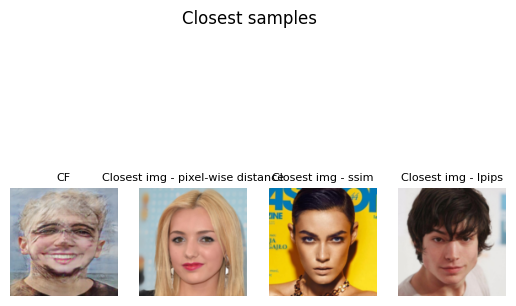

In [77]:
# Closest sample using average pixel-wise distance

%matplotlib inline

cf_index = np.random.randint(0, count_valid_cfs)
cf_sample_tensor = transforms.functional.resize(valid_cf_images[cf_index],[128, 128]).unsqueeze(0)
d = torch.sqrt(torch.mean((cf_sample_tensor - sample_images) ** 2, dim=[1, 2, 3]))
closest_idx_pixel_wise = torch.argmin(d)
closest_sample_pw = sample_images[closest_idx_pixel_wise]
closest_sample_pw = normalize_0_1(closest_sample_pw)
closest_sample_pw = closest_sample_pw.squeeze(0).permute(1, 2, 0).cpu().numpy()

ssim_distances = []
for s in sample_images:
  sim = ssim(cf_sample_tensor, s.unsqueeze(0))
  ssim_distances.append(sim)
ssim_distances = torch.stack(ssim_distances)

closest_idx_ssim = torch.argmin(torch.abs(ssim_distances))
closest_sample_ssim = sample_images[closest_idx_ssim]
closest_sample_ssim = normalize_0_1(closest_sample_ssim)
closest_sample_ssim = closest_sample_ssim.squeeze(0).permute(1, 2, 0).cpu().numpy()

lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg', reduction='none')
lpips_distances = lpips(cf_sample_tensor.expand(100, 3, 128, 128), sample_images)

closest_idx_lpips = torch.argmin(torch.abs(lpips_distances))
closest_sample_lpips = sample_images[closest_idx_lpips]
closest_sample_lpips = normalize_0_1(closest_sample_lpips)
closest_sample_lpips = closest_sample_lpips.squeeze(0).permute(1, 2, 0).cpu().numpy()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
cf_sample = normalize_0_1(cf_sample_tensor).squeeze(0).permute(1, 2, 0).cpu().numpy()
ax1.imshow(cf_sample)
ax2.imshow(closest_sample_pw)
ax3.imshow(closest_sample_ssim)
ax4.imshow(closest_sample_lpips)
ax1.title.set_text('CF')
ax1.title.set_fontsize(8)
ax2.title.set_text('Closest img - pixel-wise distance')
ax2.title.set_fontsize(8) 
ax3.title.set_text('Closest img - ssim')
ax3.title.set_fontsize(8) 
ax4.title.set_text('Closest img - lpips')
ax4.title.set_fontsize(8) 
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
fig.suptitle('Closest samples')

In [ ]:
# FID score

fid = FrechetInceptionDistance(normalize = True)
fid.update(img_a, real=True)
fid.update(img_fake, real=False)
fid.compute()

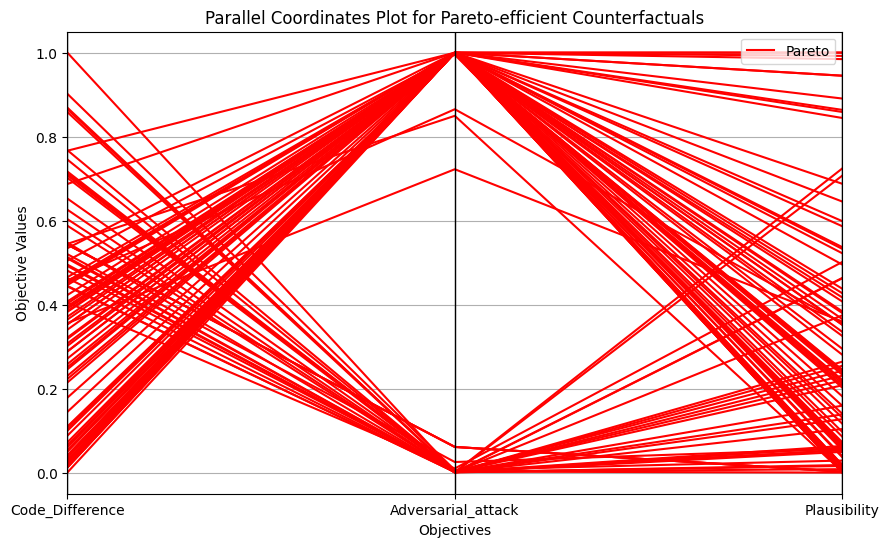

In [1167]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

# Suppose you have your solver solutions in a list
# Each solution has solution.objectives = [f1, f2, f3]
results = []
# Convert to DataFrame

df = pd.DataFrame({
    'Code_Difference': x_data,
    'Adversarial_attack': y_data,
    'Plausibility': z_data
})

# Add a dummy label since all solutions are Pareto-efficient
df['label'] = 'Pareto'

# Parallel coordinates plot
plt.figure(figsize=(10,6))
parallel_coordinates(df[['Code_Difference','Adversarial_attack','Plausibility','label']], 'label', color=('#ff0000'))
plt.title('Parallel Coordinates Plot for Pareto-efficient Counterfactuals')
plt.xlabel('Objectives')
plt.ylabel('Objective Values')
plt.show()
